# ElectroCardioGraphy R peaks detection

A distinctive characteristic of the Electrocardiographic signals is their periodicity which is not common in physiological terms. due to this characteristic the study of cardiac cycle variability defines an important segment of ECG analysis. heart rate analysis depends on the detection of ECG R peaks.

The detection of these peaks is the topic of this practical experience. This is done using the Pan-Tompkins algorithm, translated into Python by Raja Selvaraj. The Pan–Tompkins algorithm is commonly used to detect QRS complexes in electrocardiographic signals (ECG). The QRS complex represents the ventricular depolarization and the main spike visible in an ECG signal.

## Data analysis 

First step is to load the needed packages:

In [1]:
# biosignalsnotebooks python package
import biosignalsnotebooks as bsnb

# Package used for loading data from the input h5 file
import h5py
from h5py import File

# Scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We then import the three recorded signals by entering the absolute path.

In [2]:
file_path = "C://Users//smarocco.inst//Desktop//SUPSI//WORK//LAB BioSgn//aux_files//biosignalsnotebooks_environment//signal_samples//msig.h5"
h5_object = File(file_path)

The objects we are going to analyze are files of type .h5.

Let us proceed to analyze the composition of the file in a hierarchical manner:

In [3]:
# Keys list (.h5 hierarchy ground level)
list(h5_object.keys())

['88:6B:0F:F1:97:6E']

In [4]:
h5_group = h5_object.get('88:6B:0F:F1:97:6E')
print ("Second hierarchy level: " + str(list(h5_group)))

Second hierarchy level: ['digital', 'events', 'plugin', 'raw', 'support']


In [5]:
print ("Metadata of h5_group: \n" + str(list(h5_group.attrs.keys())))

Metadata of h5_group: 
['channels', 'comments', 'date', 'device', 'device connection', 'device name', 'digital IO', 'duration', 'firmware version', 'keywords', 'macaddress', 'mode', 'nsamples', 'resolution', 'sampling rate', 'sync interval', 'time']


Confirm that the signal has been sampled with the desired frequency, we can access the "sampling rate" metadata.

In [6]:
sampling_rate = h5_group.attrs.get("sampling rate")
print ("Sampling Rate: " + str(sampling_rate))

Sampling Rate: 1000


For this experiment we are interested in manipulating data from sensors, so we are going to modify the "raw" data.  We therefore access the third hierarchical level of the data format.

In [7]:
h5_sub_group = h5_group.get("raw")
print("Third hierarchy level: " + str(list(h5_sub_group)))

Third hierarchy level: ['channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'nSeq']


From here the recorded data for each sensor channel can be accessed. In our case we will use the data recorded on channel 1. 

In [8]:
h5_data = h5_sub_group.get("channel_1")

# Conversion of a nested list to a flatten list by list-comprehension
# The following line is equivalent to:
# for sublist in h5_data:
#    for item in sublist:
#        flat_list.append(item)
data_list = [item for sublist in h5_data for item in sublist]
# Signal data samples values and graphical representation.
print (np.array([item for sublist in h5_data for item in sublist]))

[508 507 506 ... 539 553 560]


To facilitate data manipulation operations we transform a nested list to a flatten list. We then generate the signal reference time using the function bsnb.generate_time(). 

In [9]:
# Signal Samples.
signal = data_list

#Time generation
time = bsnb.generate_time(signal)

We can now apply the Pan-Tompkins Algorithm. The first step will be to apply a band pass filter. This filter is applied to increase the signal-to-noise ratio. A filter bandwidth of 5-15 Hz is suggested to maximize the QRS contribute and reduce muscle noise, baseline wander, powerline interference and the P wave(atrial depolarization)/T wave(repolarization of the ventricles) frequency content. In the original algorithm proposed in 1985, the band-pass filter was obtained with a low-pass filter and a high-pass filter in cascade to reduce the computational cost and allow a real-time detection, while ensuring a 3 dB passband in the 5–12 Hz frequency range, reasonably close to the design goal.

In [10]:
# Step 1 of Pan-Tompkins Algorithm
filtered_signal = bsnb.detect._ecg_band_pass_filter(signal, sampling_rate)

It is always good practice to plot the data obtained, to verify the result achieved by the first step of the Pan-Tompkins algorithm. We use two subplots, in the first we plot the original signal, in the second the signal filtered, for both signal use time as x-axis.

Tip: Limit the x-axis between 0s and 4s.

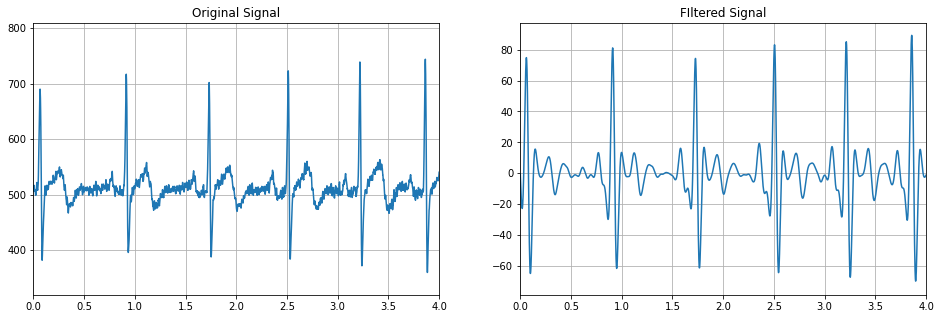

In [11]:
# Create two subplots one with the original signal and the other with the signal processed
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(time, signal)
ax1.set_title('Original Signal')
ax1.set_xlim([0, 4])
ax1.grid()
ax2.plot(time, filtered_signal)
ax2.set_title('FIltered Signal')
ax2.set_xlim([0, 4])
ax2.grid()

The second step of the algorithm is to apply a derivative filter to provide information about the slope of the QRS. 

Tip: check np.diff() 

In [12]:
# Step 2 of Pan-Tompkins Algorithm
differentiated_signal = np.diff(filtered_signal)

In order to plot a graph of the two signals in comparison, however, it is necessary to generate a time-based x-axis for the differentiated_signal as well. 

In [13]:
time_diff = bsnb.generate_time(differentiated_signal)

We then create two more subplots that allow the comparison between the previously filtered signal and the post-derivative filtered signal. 

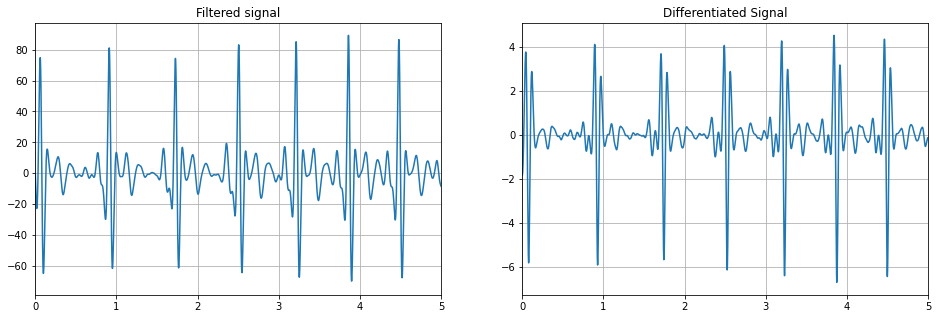

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(time, filtered_signal)
ax1.set_title('Filtered signal')
ax1.set_xlim([0, 5])
ax1.grid()
ax2.plot(time_diff, differentiated_signal)
ax2.set_title('Differentiated Signal')
ax2.set_xlim([0, 5])
ax2.grid()

The third step of the Pan-Tompkins algorithm is to rectify the signal. This is done to enhance the dominant peaks (QRSs) and reduce the possibility of erroneously recognizing a T wave as an R peak.

In [15]:
# Step 3 of Pan-Tompkins Algorithm
squared_signal = differentiated_signal * differentiated_signal

Again by plotting the two graphs:

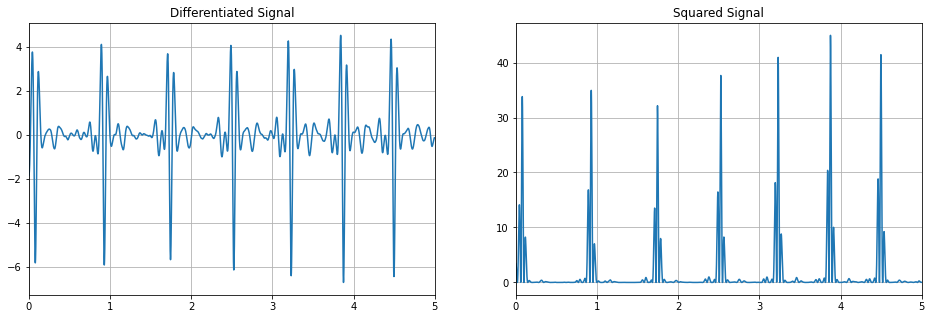

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(time_diff, differentiated_signal)
ax1.set_title('Differentiated Signal')
ax1.set_xlim([0, 5])
ax1.grid()
ax2.plot(time_diff, squared_signal)
ax2.set_title('Squared Signal')
ax2.set_xlim([0, 5])
ax2.grid()

The last step of the algorithm is done by applying a moving average filter to provide information about the duration of the QRS complex. The number of samples to average is chosen in order to average on windows of the desired time. Number of sample is saved in the variable nbr_sampls_int_wind, meanwhile the integrated signal samples will be saved in the variable integrated_signal. However it is first needed to clead this variable.

In [17]:
nbr_sampls_int_wind = int(0.080 * sampling_rate)

integrated_signal = np.zeros_like(squared_signal)

We want now to determine a cumulative version of the squared_signal. In the cumulative version of the signal under analysis, his sample value i will be sum of all values included between entry 0 and entry i of the studied signal (in our case "squared_signals").

In [18]:
cumulative_sum = squared_signal.cumsum()

We want to make an estimate of the area/integral below the curve that defines the "squared_signal".Implicitly, with the current procedure, "squared_signal" is divided into multiple rectangles with fixed width (equal 1 sample) and height determined by the sample value under analysis. Basically we are using the Riemann sum to compute the integral.

In mathematics, a Riemann sum is a certain kind of approximation of an integral by a finite sum. One very common application is approximating the area of functions or lines on a graph, but also the length of curves and other approximations.

The sum is calculated by partitioning the region into shapes (rectangles, trapezoids, parabolas, or cubics) that together form a region that is similar to the region being measured, then calculating the area for each of these shapes, and finally adding all of these small areas together. This approach can be used to find a numerical approximation for a definite integral even if the fundamental theorem of calculus does not make it easy to find a closed-form solution. 

In [19]:
integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - 
                                           cumulative_sum[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)

Let's compare the graphs of the two signals again to check that the integration procedure via Riemann sum worked. 

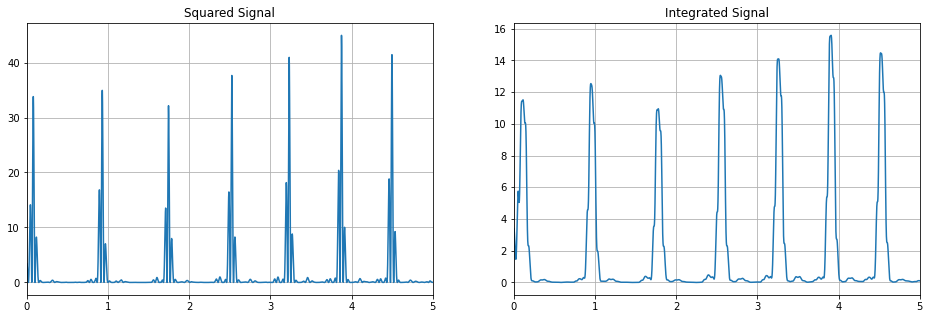

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(time_diff, squared_signal)
ax1.set_title('Squared Signal')
ax1.set_xlim([0, 5])
ax1.grid()
ax2.plot(time_diff, integrated_signal)
ax2.set_title('Integrated Signal')
ax2.set_xlim([0, 5])
ax2.grid()

We can now try to apply the ECG simplified version to a sequence of peak identification steps, this is done by using a threshold system. To reduce the possibility of wrongly selecting a noise peak as a QRS, each peak amplitude is compared to a threshold that takes into account the available information about already detected QRS and the noise level:
$$
  Threshold = NoiseLevel + 0.25(SignalLevel - NoiseLevel)
$$
where NoiseLevel is the running estimate of the noise level in the integrated signal and SignalLevel is the running estimate of the signal level in the integrated signal

The threshold is automatically updated after detecting a new peak, based on its classification as signal or noise peak: 
\begin{align}
SignalLevel &= 0.125PEAK + 0.875SignalLevel (if PEAK is a signal peak)\\
NoiseLevel &= 0.125PEAK + 0.875NoiseLevel (if PEAK is a noise peak)\\
\end{align}
where PEAK is the new peak found in the integrated signal. 

If a new PEAK is under the Threshold, the noise level is updated. If PEAK is above the Threshold, the algorithm implements a further check before confirming the peak as a true QRS, taking into consideration the information provided by the bandpass filtered signal.

In the filtered signal the peak corresponding to the one evaluated on the integrated signal is searched and compared with a threshold, calculated in a similar way to the previous step: 
\begin{align}
Threshold_F &= NoiseLevel_F + 0.25(SignalLevel_F - NoiseLevel_F)\\
SignalLevel_F &= 0.125PEAK + 0.875SignalLevel_F (if PEAK_F is a signal peak)\\
NoiseLevel_F &= 0.125PEAK + 0.875NoiseLevel_F (if PEAK_F is a noise peak)\\
\end{align}
where the final F stands for filtered signal.

We can now initialize the R peak detetction algorithm

In [21]:
rr_buffer, signal_peak_1, noise_peak_1, threshold = bsnb.detect._buffer_ini(integrated_signal, sampling_rate)

Each sample i of our signal is a possible peak if his value is greater than the ones at sample i−1 and i+1. On the other hand, a probable peak is a possible peak that meets some criteria defined by Pan and Tompkins and synthesised inside _detect_peaks function of biosignalsnotebooks Python package. 

In [22]:
probable_peaks, possible_peaks= bsnb.detect._detects_peaks(integrated_signal, sampling_rate)

Values "0" of the returned result contains the list of probable peaks, while values "1" refers to the possible_peaks.

Taken into consideration the list of previously detected probable peaks, a set of additional criteria were defined by Pan and Tompkins, in order to exclude peaks from the list of probable peaks. 

In [23]:
definitive_peaks = bsnb.detect._checkup(probable_peaks, integrated_signal, sampling_rate, rr_buffer, signal_peak_1, noise_peak_1,
                                        threshold)

In [24]:
detected_peaks = bsnb.detect_r_peaks(signal, sampling_rate, time_units=True, plot_result=True)

## Signal to Noise Ratio

In addition to the signal itself, a key parameter to consider is the signal to noise ratio (SNR) a metric that classifies objectively the quality of the acquisition, and like the name suggests, the relation between the intensity of the signal and the undesired noise in the acquired data, which is defined by: 

$$SNR = \frac{V_{pp}signal}{V_{pp}noise}$$

To obtain this parameter, there is a big difference in the procedure when applying it to slow and rapid signals. Slow signals, as expected, have slow oscillations. To find the noise signal, you just have to subtract the filtered signal to the raw one. However, when it comes to rapid signals, such as the electrocardiography (ECG) signal, you would not have a correct noise signal this way. 

In the second part of this experience we will see how to compute the SNR values for ECG signals. 

In [25]:
# Importing specific functions from the numpy Python package
from numpy import ptp, zeros, mean

# biosignalsnotebooks python package
import biosignalsnotebooks as bsnb

# Package to calculate SNR with log
from math import log10

The amplitude of the signal is: 0.0203704833984375 mV


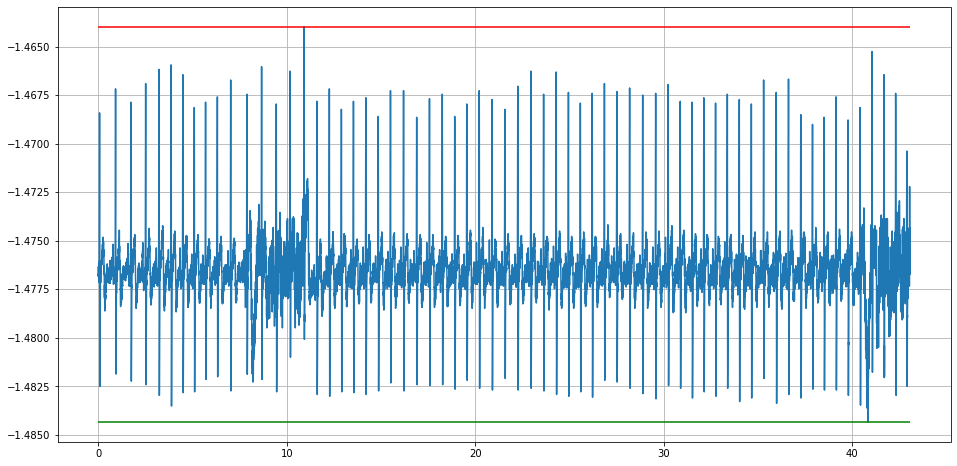

In [39]:
# Converting from rwa data to mV (check the datasheet)
signal_v = (((np.array(signal)/(2**16))-0.5)*3)/1000
signal_mv = signal_v*1000
# Finding the maximum and minimum values of the ECG signal
max_ecg = max(signal_mv)
min_ecg = min(signal_mv)

# Calculating the amplitude of the signal
vpp_signal_ecg = max_ecg - min_ecg

# Print the amplitude of the signal
print("The amplitude of the signal is:", vpp_signal_ecg, "mV")

# Notice that this procedure is condensed in a single function in the numpy Python package:
vpp_signal_ecg = ptp(signal_mv)

# Visualize it with the lines of the maximum and minimum values of the ECG signal
time_ecg = bsnb.generate_time(signal_v)
plt.figure(figsize=(16, 8))
plt.plot(time_ecg, signal_mv)
plt.hlines(y=max_ecg, xmin = 0, xmax = time_ecg[-1], colors = 'r')
plt.hlines(y=min_ecg, xmin = 0, xmax = time_ecg[-1], colors = 'g')
plt.grid()

In order to measure peak to peak amplitude for the  noise component on repetitive and fast varying signals, specifically ECG signals: 

1. Slice the signal into several single-beat signals 
1. Compute the amplitude from all the areas where there is no presence of ECG signal and average all the obtained values to define the final Vpp noise value 

The typical heartbeat in an ECG signal is composed by various waves that correspond to specific events in the heart. Specifically, there are the P, Q, R, S and T waves that occur in the heart during the contraction and relaxation of the atria, and contraction and relaxation of the ventricles. Being the R peak the most noticeable wave of each heartbeat, algorithms for heartbeat detection usually focus on finding these structures.

As we already done in the first part of the experience it is enough to use the bsnb function. 

In [27]:
time_r_peaks, amplitude_r_peaks = bsnb.detect_r_peaks(signal_mv, sampling_rate, time_units=True, plot_result= True)

In order to explain the used method to calculate the SNR for ECG signals, in this laboratory we are using just one beat - for example the fifth one. As previously mentioned, it is needed to slice the noise segment in intervals to minimize errors when measuring noise signal amplitude. We broke it into 20 intervals.

In [28]:
# Time of the onset of the sixth R peak (remember that Python lists and arrays start at 0)
onset_sixth_hb = time_r_peaks[6]

# Time of the onset of the fifth R peak
onset_fifth_hb = time_r_peaks[5]

# The start of the noise corresponds to the interval between peaks. Through observation, the fifth heartbeat ends at
# around 0.5 s after its start, while the sixth starts at around 0.65 s after the start of the previous
time_start_noise = onset_sixth_hb + 0.3
time_end_noise = onset_sixth_hb + 0.5

# Then, we need to convert it to index to identify it in the signal. The values are cast to integers because all indexes are integers.
start_noise = int(time_start_noise * sampling_rate)
end_noise = int(time_end_noise * sampling_rate)

# Now we will identify the heartbeats. The procedure is analogous, and so we will do it in single lines.
# The parcels of 0.7 and 1.5 correspond to empirical values that need to be added to the R peaks in order
# to identify the onset of the heartbeats, once they do not start with the R peaks.
time_start = time_ecg[int((onset_fifth_hb + .7)*sampling_rate):start_noise]
beat_start = signal_mv[int((onset_fifth_hb+ .7)*sampling_rate):start_noise]

time_end = time_ecg[end_noise:int((onset_sixth_hb + 1.5)*sampling_rate)]
beat_end = signal_mv[end_noise:int((onset_sixth_hb + 1.5)*sampling_rate)]

# signal with noise values
time_noise = time_ecg[start_noise:end_noise]
beat_noise = signal_mv[start_noise:end_noise]

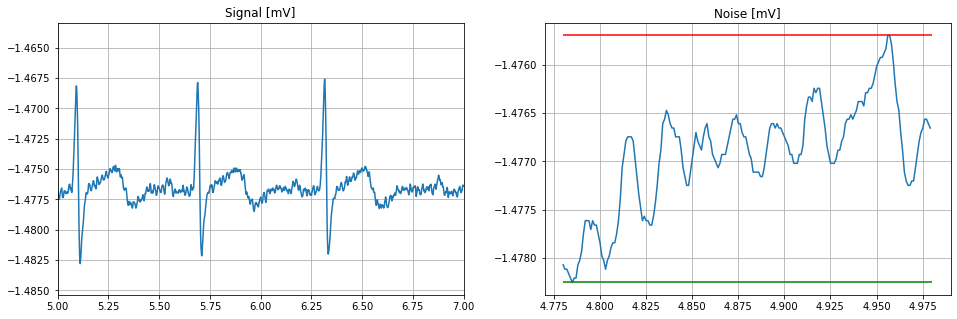

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(time_ecg, signal_mv)
ax1.set_title('Signal [mV]')
ax1.set_xlim([5, 7])
ax1.grid()
ax2.plot(time_noise, beat_noise)
ax2.set_title('Noise [mV]')
ax2.hlines(y = beat_noise.max(), xmin = time_ecg[start_noise], xmax = time_ecg[end_noise], colors = 'r')
ax2.hlines(y = beat_noise.min(), xmin = time_ecg[start_noise], xmax = time_ecg[end_noise], colors = 'g')
ax2.grid()

To get a more precise value for the amplitude of noise, one should consider the noise present in the signal as a whole . However, once ECG signal is composed of high and low frequency components, it is not possible to just separate noise using either a low pass or a high pass filter. Thus, our approach is to identify every interval between heartbeats, that should correspond to flat lines with no signal. Thus, by getting the average value of the amplitude of those segments, we get an estimate of the amplitude of the noise in the signal. 

In [30]:
vpp_noise_ecg = []

# For this task, we will follow the same procedure as shown before, but store the values in a list, so that we can then calculate the mean value.
for t in time_r_peaks:
    start = int((t + 0.5) * sampling_rate) # 0.5 - time between a peak and a flat 
    end = int((t + 0.65)* sampling_rate) # 0.65 time between a peak and the end of the flat
    interval = signal_mv[start:end]
    vpp = ptp(interval)
    vpp_noise_ecg.append(vpp)
    
vpp_noise_ecg = mean(vpp_noise_ecg)
print("Amplitude of noise signal:" ,vpp_noise_ecg)

Amplitude of noise signal: 0.0077419281005859375


It is more usual to represent the noise in decibels (dB). This conversion can be done using the following equation:

$$ SNR = 20 \cdot log_{10} \frac{V_{pp}signal}{V_{pp}noise}$$

In [31]:
snr_ecg = vpp_signal_ecg/vpp_noise_ecg

# The multiplication by 20 is because the signals are in the unit of (micro)Siemes
snr_ecg_db = 20 * log10(snr_ecg)

print("SNR for ECG signal: {}".format(snr_ecg))
print("SNR for ECG signal: {} dB".format(snr_ecg_db))

SNR for ECG signal: 2.631189948263119
SNR for ECG signal: 8.403044027505045 dB


## Non-linearity 

In several cases, the signal may be degraded by non-linearities due to sensors, a clear example being the setting time of the sensor.

A non-linear function that can demonstrate the concept just described is the sigmoind function. Which is a mathematical function having a characteristic "S"-shaped curve or sigmoid curve.
A common example of a sigmoid function is the logistic function shown in the figure and defined by the formula:

$$ S(x) = \frac{1}{1+e^{-x}} $$

Typically, one tries to work in an area of the function that can be regarded as linear, in order to have an output value that reflects the input value.

The sigmoid function is defined below, apply it to the signal from the sensor and evaluate its influence

In [115]:
def sigmoid(x):
    return 1 / (0.1 + np.exp(-x))

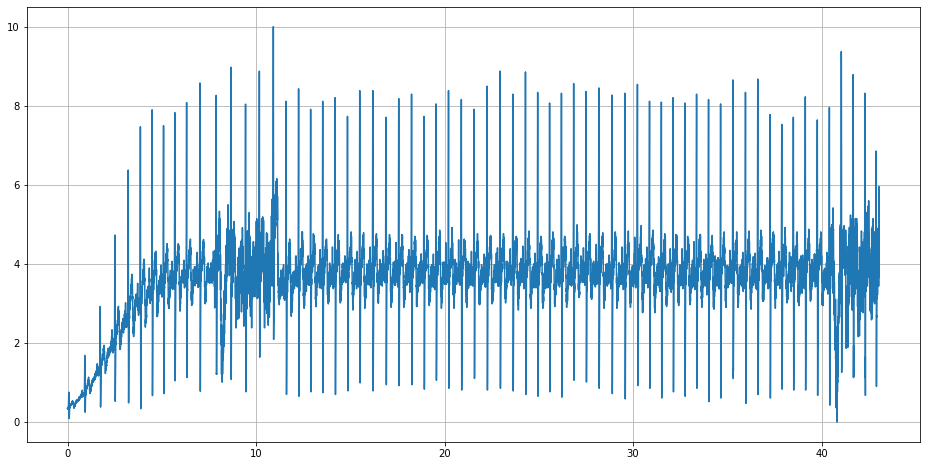

In [116]:
non_lin = sigmoid(np.array(time))*((signal - min(signal))/(max(signal)-min(signal)))
plt.figure(figsize=(16, 8))
plt.plot(time, non_lin)
plt.grid()

A further factor to consider when analysing signals is white noise.  White noise is a particular type of noise characterised by the absence of periodicity in time and constant amplitude across the entire frequency spectrum.

Using the numpy library function random.normal, white noise can be added to the signal. Try changing the two parameters of the function loc and scale and evaluate the effects on the signal. 

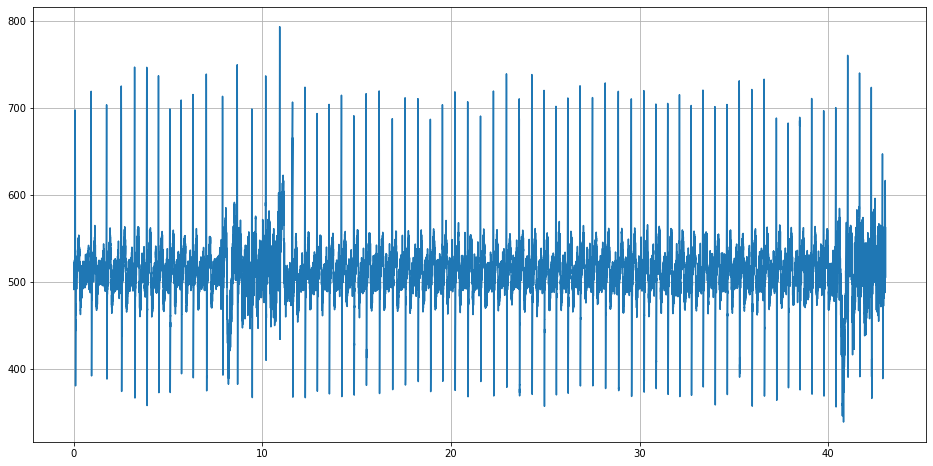

In [117]:
white_noise= np.random.normal(loc=0.0, scale=5, size=len(time))
gaussian = white_noise + signal
plt.figure(figsize=(16, 8))
plt.plot(time, gaussian)
plt.grid()